# Competition Reward Function Visualization

This notebook visualizes the competition reward function from `src/cts_recommender/environments/reward.py`.

Any changes to the reward function will automatically be reflected here.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import sys
from pathlib import Path

# Extract the competition reward logic into a standalone function for visualization
def competition_reward(d: float) -> float:
    """
    Competition reward function extracted from RewardCalculator._calculate_competition_reward.
    
    Args:
        d: Days difference (RTS air_date - competitor air_date)
           Negative = RTS airs BEFORE competitor (good)
           Positive = RTS airs AFTER competitor (bad, but recovers)
    
    Returns:
        Reward value in range [0.0, 1.0]
    """
    # This implements the same logic as RewardCalculator._calculate_competition_reward
    # Copy the logic from reward.py:144-174
    
    if 0 <= d <= 183:
        # 0-6 months after: no advantage
        return 0.0
    elif 183 < d <= 365:
        # 6 months to 1 year after: linear recovery to 0.2
        return 0.2 * (d - 183) / 183.0
    elif d > 365:
        # Over 1 year after: neutral
        return 0.2
    elif -4 <= d <= -1:
        # 1-4 days before: peak advantage
        return 1.0
    elif -21 < d < -4:
        # 4-21 days before: exponential rise from 0.4 to 1.0
        a = 0.25
        num = np.exp(a * (d + 21)) - 1.0
        den = np.exp(a * 17.0) - 1.0
        return 0.4 + 0.6 * (num / den)
    elif d <= -21:
        # More than 21 days before: neutral
        return 0.2
    elif -1 < d < 0:
        # Less than 1 day before: linear decay from 1.0 to 0.2
        t = d + 1.0
        return 1.0 * (1 - t) + 0.2 * t
    elif d == 0:
        # Same day: neutral
        return 0.2
    else:
        # Default fallback
        return 0.2

# Verify the function is imported correctly
print(f"✓ Competition reward function ready for visualization")

✓ Competition reward function ready for visualization


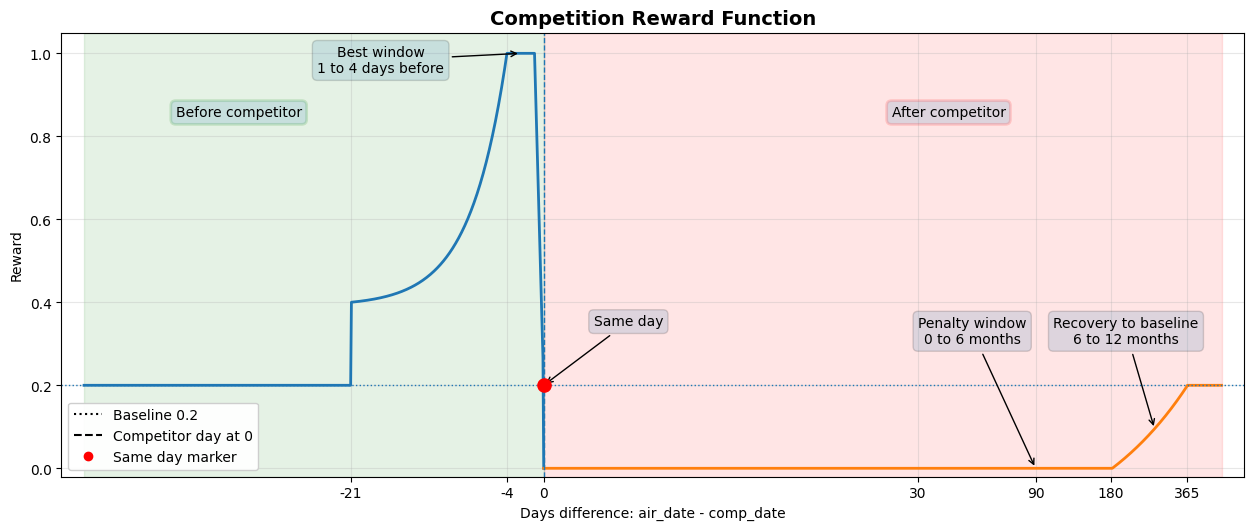

In [5]:
# Nonlinear x-scaling with more stretch around [-4, 0]
def x_transform(d: float, after_scale: float = 140.0) -> float:
    if d <= 0:
        return d * 2  # stretch the before side, esp near -4 to 0
    return np.log1p(d) * (after_scale / np.log1p(365.0))

# Sample
xs_before = np.linspace(-50, 0, 601)
xs_after  = np.linspace(0, 500, 721)
ys_before = [competition_reward(x) for x in xs_before]
ys_after  = [competition_reward(x) for x in xs_after]
xt_before = [x_transform(x) for x in xs_before]
xt_after  = [x_transform(x) for x in xs_after]

fig, ax = plt.subplots(figsize=(13, 6))

# Shading: green before, red after
ax.axvspan(x_transform(-50), x_transform(0), alpha=0.1, color="green")
ax.axvspan(x_transform(0), x_transform(500), alpha=0.1, color="red")

# Curve
ax.plot(xt_before, ys_before, linewidth=2)
ax.plot(xt_after, ys_after, linewidth=2)

# Baseline and competitor day
ax.axhline(0.2, linestyle=":", linewidth=1)
ax.axvline(x_transform(0), linestyle="--", linewidth=1)

# Same day red dot at baseline
ax.scatter([x_transform(0)], [0.2], s=90, color="red", zorder=5)

# X ticks (all bottom, no overlap)
tick_days = [-21, -4, 0, 30, 90, 180, 365]
ax.set_xticks([x_transform(d) for d in tick_days])
ax.set_xticklabels([str(d) for d in tick_days], fontsize=10)

# Annotation boxes
bbox_common = dict(boxstyle="round,pad=0.35", alpha=0.15)

# Outline for before competitor (green)
ax.text(0.15, 0.82, "Before competitor",
        transform=ax.transAxes, ha="center", va="center",
        bbox=dict(boxstyle="round,pad=0.35", alpha=0.15, edgecolor="green", linewidth=2))

# Outline for after competitor (red)
ax.text(0.75, 0.82, "After competitor",
        transform=ax.transAxes, ha="center", va="center",
        bbox=dict(boxstyle="round,pad=0.35", alpha=0.15, edgecolor="red", linewidth=2))

# Arrows for the rest
ax.annotate("Best window\n1 to 4 days before",
            xy=(x_transform(-2.5), 1.0), xycoords="data",
            xytext=(0.27, 0.91), textcoords="axes fraction",
            arrowprops=dict(arrowstyle="->", linewidth=1),
            bbox=bbox_common, ha="center")

ax.annotate("Same day",
            xy=(x_transform(0), 0.2), xycoords="data",
            xytext=(0.45, 0.34), textcoords="axes fraction",
            arrowprops=dict(arrowstyle="->", linewidth=1),
            bbox=bbox_common, ha="left")

ax.annotate("Penalty window\n0 to 6 months",
            xy=(x_transform(90), competition_reward(90)), xycoords="data",
            xytext=(0.77, 0.30), textcoords="axes fraction",
            arrowprops=dict(arrowstyle="->", linewidth=1),
            bbox=bbox_common, ha="center")

ax.annotate("Recovery to baseline\n6 to 12 months",
            xy=(x_transform(270), competition_reward(270)), xycoords="data",
            xytext=(0.90, 0.30), textcoords="axes fraction",
            arrowprops=dict(arrowstyle="->", linewidth=1),
            bbox=bbox_common, ha="center")

# Labels and limits
ax.set_title("Competition Reward Function", fontsize=14, weight="bold")
ax.set_xlabel("Days difference: air_date - comp_date")
ax.set_ylabel("Reward")
ax.set_ylim(-0.02, 1.05)
ax.margins(x=0.02)

# Legend
legend_handles = [
    Line2D([0], [0], color="black", linestyle=":", label="Baseline 0.2"),
    Line2D([0], [0], color="black", linestyle="--", label="Competitor day at 0"),
    Line2D([0], [0], marker="o", color="red", linestyle="None", label="Same day marker"),
]
ax.legend(handles=legend_handles, loc="lower left", framealpha=0.95)

plt.subplots_adjust(bottom=0.16, top=0.90, left=0.07, right=0.98)
ax.grid(alpha=0.3)
plt.show()

In [6]:
# Print test values to verify the function behavior
print("=== Key Reward Values ===")
print(f"{'Days':>6} | {'Reward':>7} | Description")
print("-" * 50)

test_cases = [
    (-30, "Too early before"),
    (-21, "Neutral (3 weeks before)"),
    (-14, "Rising advantage"),
    (-7, "Good timing"),
    (-4, "Peak window start"),
    (-2, "Peak window"),
    (-1, "Peak window end"),
    (-0.5, "Just before"),
    (0, "Same day"),
    (1, "1 day after"),
    (30, "1 month after (penalty)"),
    (90, "3 months after (penalty)"),
    (183, "6 months after"),
    (270, "9 months after (recovery)"),
    (365, "1 year after"),
    (400, "Over 1 year"),
]

for days, desc in test_cases:
    reward = competition_reward(days)
    print(f"{days:>6} | {reward:>7.4f} | {desc}")

=== Key Reward Values ===
  Days |  Reward | Description
--------------------------------------------------
   -30 |  0.2000 | Too early before
   -21 |  0.2000 | Neutral (3 weeks before)
   -14 |  0.4413 | Rising advantage
    -7 |  0.6788 | Good timing
    -4 |  1.0000 | Peak window start
    -2 |  1.0000 | Peak window
    -1 |  1.0000 | Peak window end
  -0.5 |  0.6000 | Just before
     0 |  0.0000 | Same day
     1 |  0.0000 | 1 day after
    30 |  0.0000 | 1 month after (penalty)
    90 |  0.0000 | 3 months after (penalty)
   183 |  0.0000 | 6 months after
   270 |  0.0951 | 9 months after (recovery)
   365 |  0.1989 | 1 year after
   400 |  0.2000 | Over 1 year
